In [ ]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.utils import save_image

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space
lr = 0.00005

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting
cuda

False

In [ ]:
n_classes = 10

In [ ]:
import math
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = math.ceil(img_size / 2 ** 4)
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator


Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
discriminator


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

print(count_parameters(generator))
print(count_parameters(discriminator))

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|     l1.0.weight      |   627200   |
|      l1.0.bias       |    6272    |
| conv_blocks.0.weight |    128     |
|  conv_blocks.0.bias  |    128     |
| conv_blocks.2.weight |   147456   |
|  conv_blocks.2.bias  |    128     |
| conv_blocks.3.weight |    128     |
|  conv_blocks.3.bias  |    128     |
| conv_blocks.6.weight |   73728    |
|  conv_blocks.6.bias  |     64     |
| conv_blocks.7.weight |     64     |
|  conv_blocks.7.bias  |     64     |
| conv_blocks.9.weight |    576     |
|  conv_blocks.9.bias  |     1      |
+----------------------+------------+
Total Trainable Params: 856065
856065
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
|   model.0.weight   |    144     |
|    model.0.bias    |     16     |
|   model.3.weight   |    4608    |
|    model.3.bias    |     32     |
|   model.6.weight   |    

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [ ]:
batch_size = 64

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define data loading step

batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
# suggested default - learning rate
lr = 0.00005
clip_value = 0.01
n_critic = 5

In [ ]:
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
sample_interval = 200

In [ ]:
# Visualize result
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



  0%|          | 0/235 [00:00<?, ?it/s]

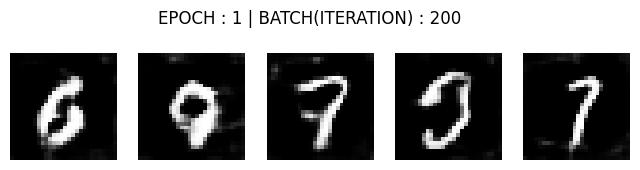

[Epoch: 1/25] [Batch: 235/235] [D loss: 0.000002] [G loss: -0.003546]


  0%|          | 0/235 [00:00<?, ?it/s]

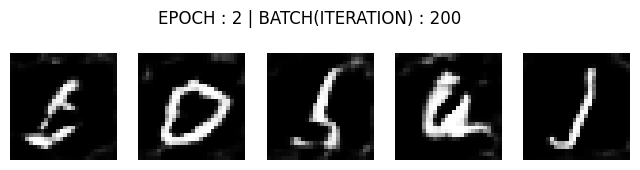

[Epoch: 2/25] [Batch: 235/235] [D loss: -0.000000] [G loss: -0.003561]


  0%|          | 0/235 [00:00<?, ?it/s]

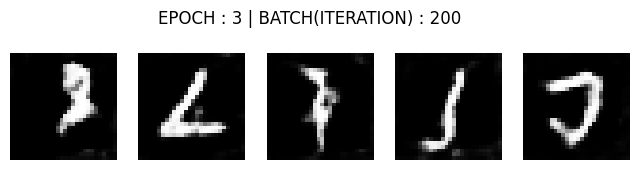

[Epoch: 3/25] [Batch: 235/235] [D loss: -0.000000] [G loss: -0.003563]


  0%|          | 0/235 [00:00<?, ?it/s]

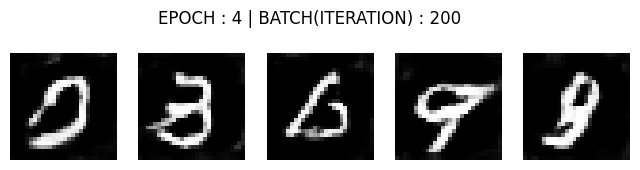

[Epoch: 4/25] [Batch: 235/235] [D loss: 0.000001] [G loss: -0.003571]


  0%|          | 0/235 [00:00<?, ?it/s]

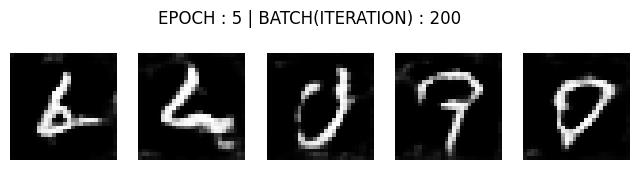

[Epoch: 5/25] [Batch: 235/235] [D loss: -0.000001] [G loss: -0.003585]


  0%|          | 0/235 [00:00<?, ?it/s]

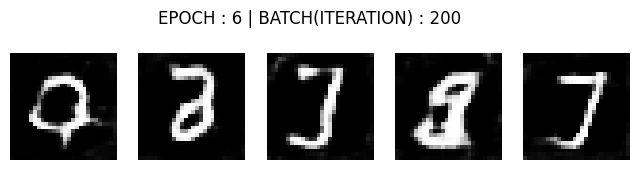

[Epoch: 6/25] [Batch: 235/235] [D loss: 0.000001] [G loss: -0.003598]


  0%|          | 0/235 [00:00<?, ?it/s]

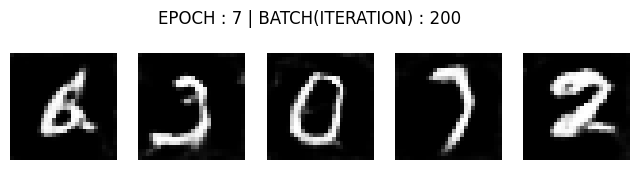

[Epoch: 7/25] [Batch: 235/235] [D loss: 0.000002] [G loss: -0.003600]


  0%|          | 0/235 [00:00<?, ?it/s]

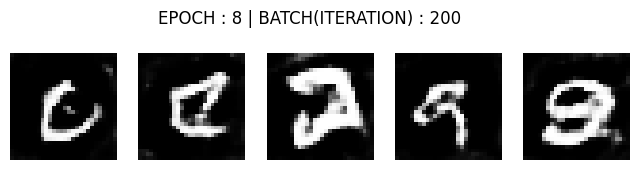

[Epoch: 8/25] [Batch: 235/235] [D loss: 0.000000] [G loss: -0.003614]


  0%|          | 0/235 [00:00<?, ?it/s]

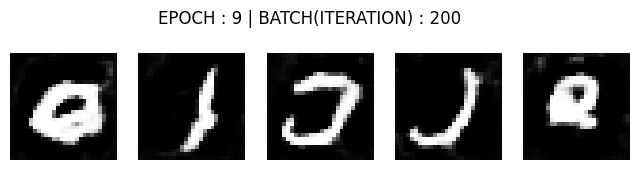

[Epoch: 9/25] [Batch: 235/235] [D loss: 0.000000] [G loss: -0.003600]


  0%|          | 0/235 [00:00<?, ?it/s]

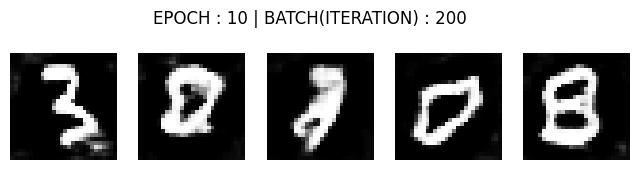

[Epoch: 10/25] [Batch: 235/235] [D loss: 0.000000] [G loss: -0.003574]


  0%|          | 0/235 [00:00<?, ?it/s]

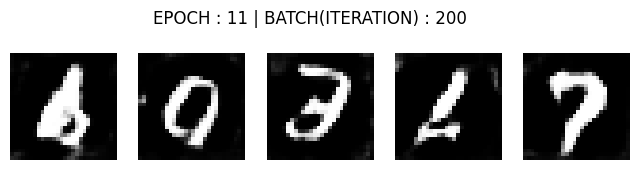

KeyboardInterrupt: ignored

In [ ]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        real_imgs = Variable(imgs.type(Tensor))
        optimizer_D.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        fake_imgs = generator(z).detach()
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
        loss_D.backward()
        optimizer_D.step()
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i % n_critic == 0:

          optimizer_G.zero_grad()
          gen_imgs = generator(z)
          loss_G = -torch.mean(discriminator(gen_imgs))
          loss_G.backward()
          optimizer_G.step()

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), loss_D.item(), loss_G.item())
    )


In [ ]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
gen_labels = Variable(LongTensor(np.random.randint(0, 1, 64)))
sample_z.shape


torch.Size([64, 100])

In [ ]:
gen_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# generated images
sample_gen_imgs = generator(sample_z, gen_labels).detach().cpu()
sample_gen_imgs.shape


torch.Size([64, 1, 28, 28])

In [ ]:
sample_z

tensor([[ 0.6992, -0.8500, -0.0608,  ...,  0.3409, -0.1906, -0.2261],
        [-2.1442,  0.7354,  1.7101,  ..., -0.2065, -0.5593,  0.2933],
        [-1.0458,  0.5229, -0.3818,  ...,  1.0772, -0.3782,  0.0617],
        ...,
        [-0.1482, -3.5027,  0.9046,  ..., -0.1874,  0.9147,  0.6183],
        [ 1.3290,  1.3970, -0.0315,  ...,  1.0073,  0.1389, -0.3026],
        [-1.5164, -0.6712,  0.4882,  ..., -1.2048, -0.0739,  0.3403]])

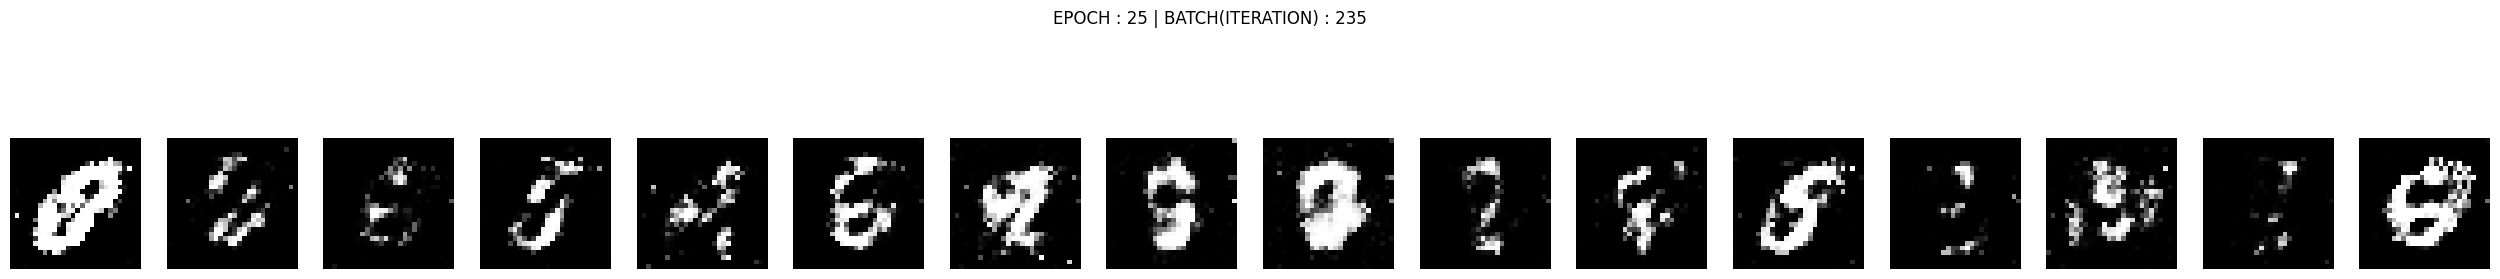

In [ ]:
nrow=1
ncols=16
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(32,4))
plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs.permute(0,2,3,1)[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

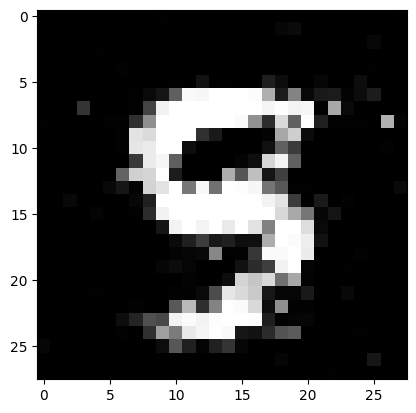

In [ ]:
show(sample_gen_imgs[3, :, :, :].detach())

In [ ]:
sample_gen_imgs[0, :, :, :].detach().shape

torch.Size([1, 28, 28])

In [ ]:
sample_gen_imgs

tensor([[[[-0.9963, -0.9916, -0.9959,  ..., -0.9988, -0.9971, -0.9953],
          [-0.9932, -0.9992, -0.9996,  ..., -0.9988, -0.9979, -0.9956],
          [-0.9932, -0.9993, -0.9976,  ..., -0.9900, -0.9956, -0.9984],
          ...,
          [-0.9870, -0.9951, -0.9867,  ..., -0.9981, -0.9993, -0.9959],
          [-0.6446, -0.9922, -0.9990,  ..., -0.9995, -0.9950, -0.9997],
          [-0.9976, -0.9942, -0.9988,  ..., -0.9819, -0.9991, -0.9965]]],


        [[[-0.9879, -0.9891, -0.9826,  ..., -0.9863, -0.9843, -0.9885],
          [-0.9854, -0.9961, -0.9976,  ..., -0.9948, -0.9965, -0.9837],
          [-0.9915, -0.9962, -0.9935,  ..., -0.8323, -0.9734, -0.9949],
          ...,
          [-0.8848, -0.9803, -0.9684,  ..., -0.9965, -0.9931, -0.9911],
          [ 0.8399, -0.9891, -0.9923,  ..., -0.9941, -0.9897, -0.9973],
          [-0.9922, -0.9712, -0.9963,  ..., -0.9908, -0.8860, -0.9836]]],


        [[[-0.9909, -0.9905, -0.9846,  ..., -0.9882, -0.9869, -0.9913],
          [-0.9872, -0.996